In [1]:
import glob, cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from vidio.read import OpenCVReader
import multicam_calibration as mcc
from multicam_calibration.detection import _generate_chessboard_anchor_template
from pathlib import Path

## Look for the calibration files

In [2]:
import h5py
from bonpy import OpenCVMovieData

video_dir = Path(r'C:\Users\Administrator\Desktop\rig_test_videos')
video_path = [f for f  in video_dir.glob('*/*/*.avi')][3]
print(video_path)
save_path = video_path.parent / (video_path.stem + ".detections.h5")

with h5py.File(save_path, "r") as h5:
    uvs = h5["uvs"][:]
    img_sizes = h5["img_size"][:]
    frame_ixs = h5["frame_ixs"][:]

movie_data = OpenCVMovieData(video_path)

# plot a random sample of 20 detections in a grid:

n = 20
ixs = np.random.choice(len(uvs), n, replace=False)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.ravel()

for i, ix in enumerate(ixs):
    img = movie_data[frame_ixs[ix]]
    ax = axs[i]
    ax.imshow(img, cmap='gray')
    ax.scatter(uvs[ix, :, 0], uvs[ix, :, 1], c='r', s=2)
    ax.axis('off')

C:\Users\Administrator\Desktop\rig_test_videos\checkerboard\checkerboard0_cropped_flipped\checkerboard0_mirror_right_flipped.avi


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\Administrator\Desktop\rig_test_videos\checkerboard\checkerboard0_cropped_flipped\checkerboard0_mirror_right_flipped.detections.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [5]:
def load_all_detected(video_path):
    video_path = Path(video_path)
    video_paths = video_path.glob("*.avi")
    qc_datas = []
    for video_path in video_paths:
        detections_path = video_path.parent / f"{video_path.stem}.detections.h5"
        assert video_path.exists(), (
            f"Could not find {detections_path}. "
            "Run `run_calibration_detection` first."
        )
        with h5py.File(detections_path, "r") as h5:
            qc_datas.append(h5["qc_data"][:]) 

    return qc_datas

In [22]:
data = load_all_detected(r'C:\Users\Administrator\Desktop\rig_test_videos')

In [23]:
print(data)

[]


In [24]:
data[0]

IndexError: list index out of range

## Copypaste from docs

In [25]:
board_shape = (5,7)
square_size = 10

# camera_names = ['top.24562653', 'side1.24548223', 'side2.24535649', 
 #                'side4.24535665', 'side3.24562655', 'bottom.24562650']

video_dir = Path(r'C:\Users\Administrator\Desktop\rig_test_videos\checkerboard\checkerboard0_cropped')
video_paths = [str(f) for f  in video_dir.glob('*.avi')]

# detect calibration object in each video
all_calib_uvs, all_img_sizes = mcc.run_calibration_detection(
    video_paths, mcc.detect_chessboard, n_workers=6,
    detection_options=dict(board_shape=board_shape, scale_factor=0.5))

# display a table with the detections shared between camera pairs
mcc.summarize_detections(all_calib_uvs)

# plot corner-match scores for each frame
# fig = mcc.plot_chessboard_qc_data(video_paths)

# optionally generate overlay videos
# for p in video_paths:
#     mcc.overlay_detections(p)


ValueError: min() arg is an empty sequence

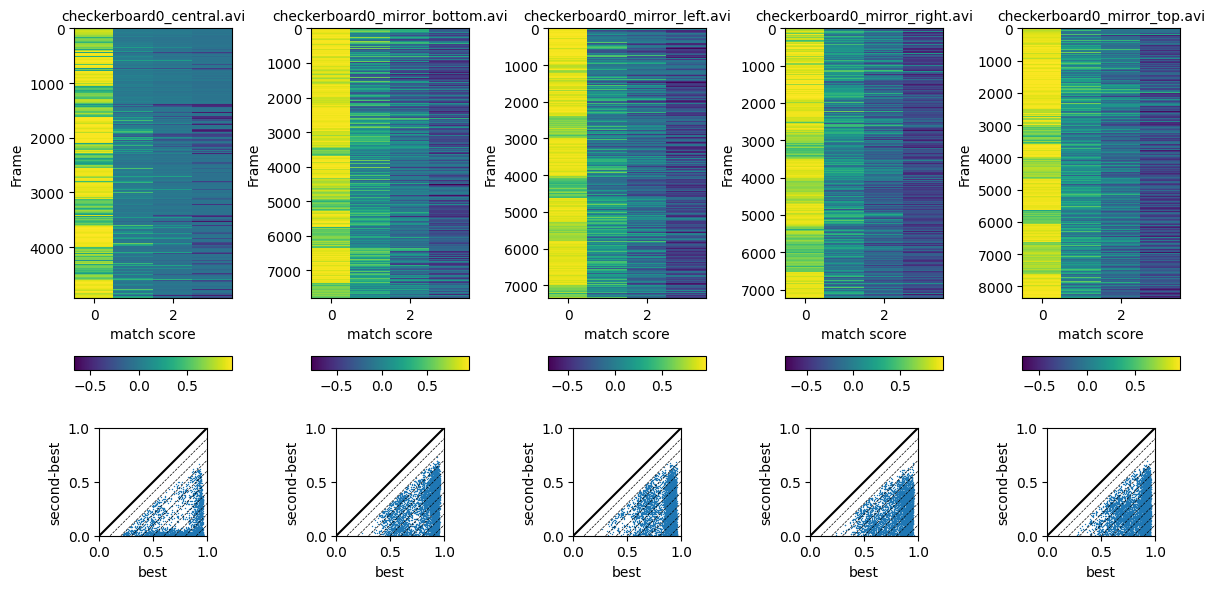

In [14]:
fig = mcc.plot_chessboard_qc_data(video_paths)

In [17]:
calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)

all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs, all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)

Estimating camera intrinsics


100%|████████████████████████████████████| 5/5 [09:23<00:00, 112.64s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]

Estimating camera extrinsics
Merging calibration object poses


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


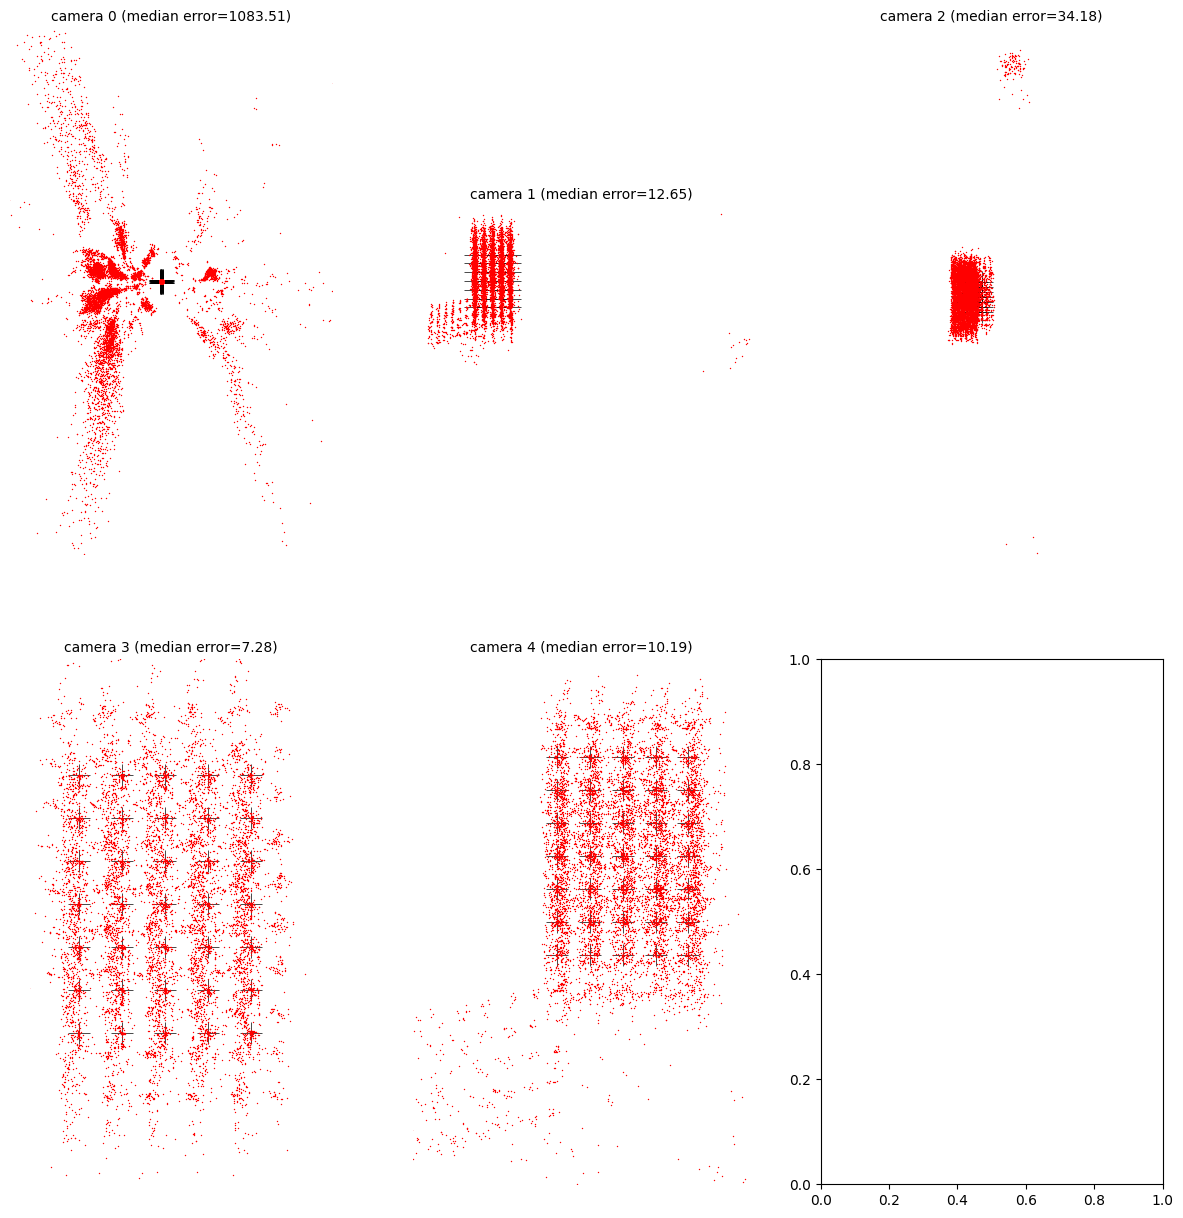

In [18]:
fig, mean_squared_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses)

In [19]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=5000, ftol=1e-4)

Excluding 4631 out of 7127 frames based on an outlier threshold of 117.85102674890803
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3333e+07                                    6.31e+07    
       1              7         1.2387e+07      9.45e+05       2.21e+03       6.15e+07    
       2              8         1.0979e+07      1.41e+06       9.32e+02       6.10e+07    
       3              9         1.0044e+07      9.35e+05       6.34e+02       6.05e+07    
       4             10         8.4948e+06      1.55e+06       9.87e+02       5.73e+07    
       5             11         6.5345e+06      1.96e+06       8.27e+02       4.90e+07    
       6             12         4.2363e+06      2.30e+06       4.52e+02       3.48e+07    
       7             13         2.7852e+06      1.45e+06       5.93e+02       7.76e+06    
       8             15         2.5093e+06      2.76e+05       8.08e+02       7.42e+06    
    

KeyboardInterrupt: 

100%|██████████| 5/5 [00:00<00:00, 26.42it/s]


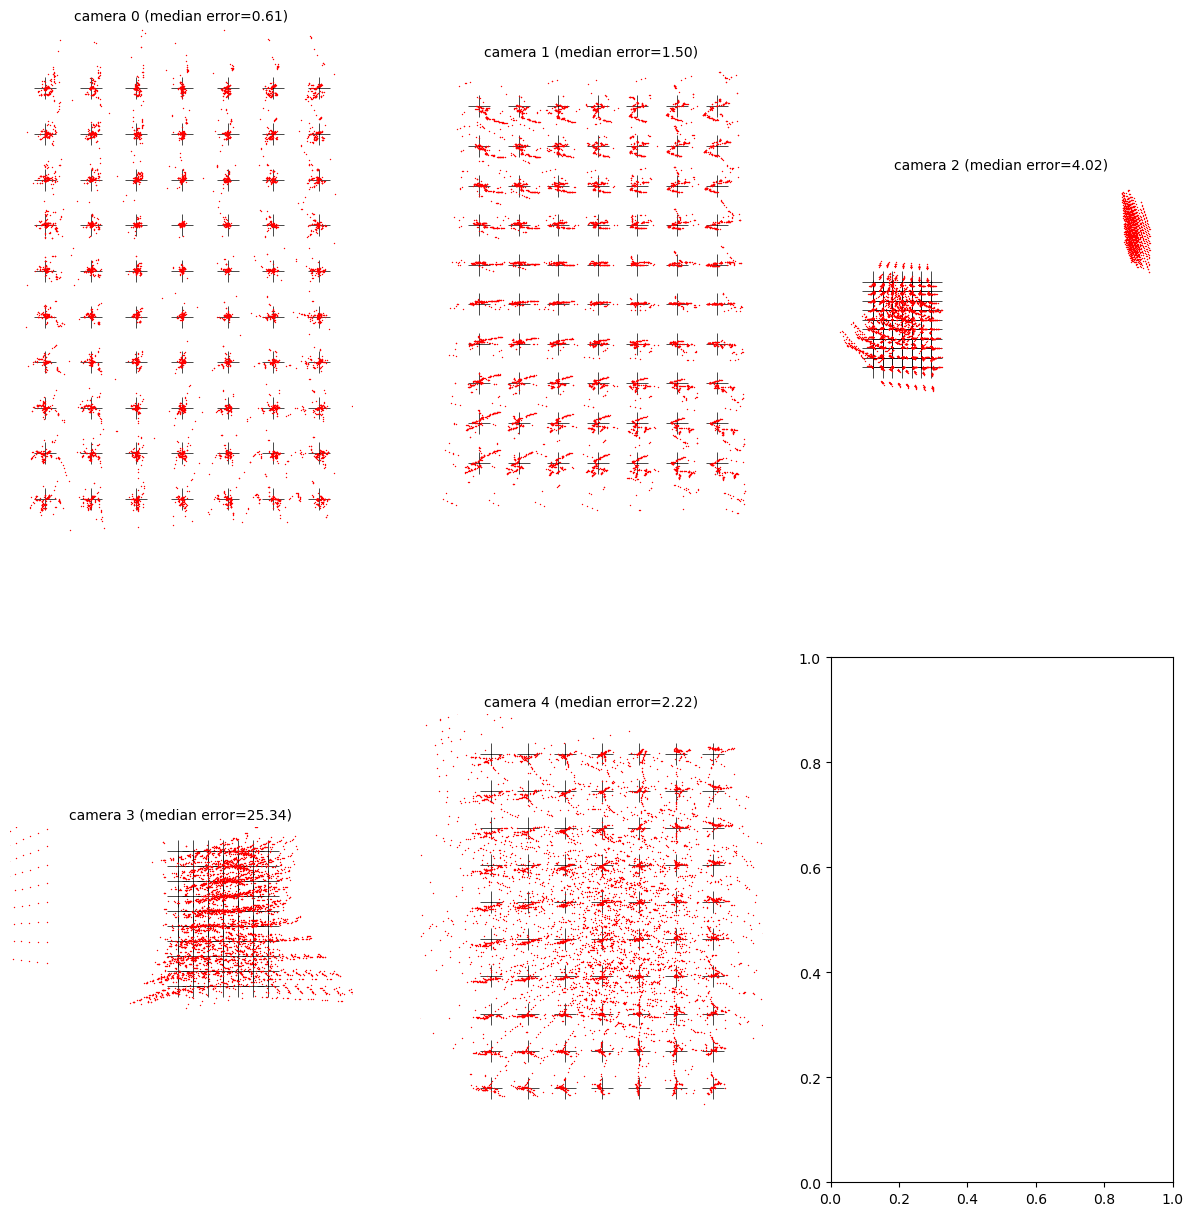

In [ ]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses)